In [11]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier

# Day 1

Accuracy: 0.9786666666666667
Precision: 0.6507936507936508
Recall: 0.803921568627451
F1 Score: 0.7192982456140351
Test Precision: 0.6607142857142857
Test Recall: 0.7254901960784313
Test F1 Score: 0.6915887850467289
[[1427   22]
 [  10   41]]


<Figure size 1000x600 with 0 Axes>

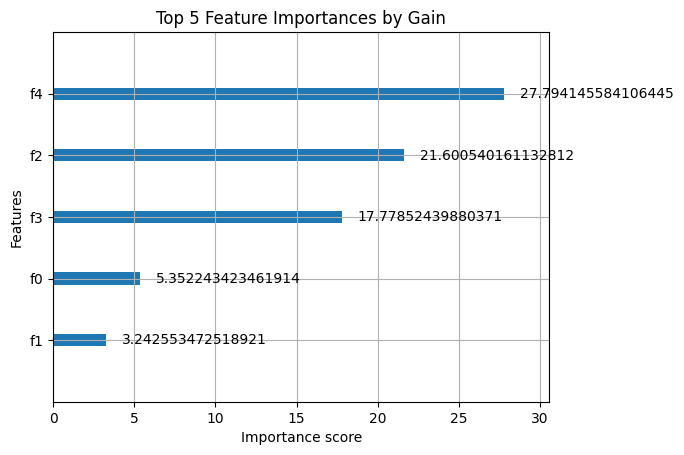

In [12]:
#importing data
df = pd.read_csv('../week_2/data/dirty_data.csv')
selected_features = pd.read_csv('../week_2/data/selected_features.csv')
Y = df['Machine failure']
X = selected_features.drop(columns=['Power [W]', 'type_encoded']) # dropping 'Power [W]' and 'type_encoded' bcs of less importance

# 1. initial split: 70 / 30
X_train, X_temp, Y_train, Y_temp = train_test_split(
    X, Y,
    test_size=0.30,
    stratify=Y,
    random_state=42
)

# 2. spliting the 30% into validation (15%) and test (15%)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, Y_temp,
    test_size=0.50,
    stratify=Y_temp,
    random_state=42
)

# 3. fitting scaler on train only
scaler = StandardScaler()
scaler.fit(X_train)

# 4. transforming all sets
X_train_scaled = scaler.transform(X_train)
X_val_scaled   = scaler.transform(X_val)
X_test_scaled  = scaler.transform(X_test)

# after splitting: applying scale_pos_weight
negatives = Y_train.value_counts()[0]
positives = Y_train.value_counts()[1]

scale_pos_weight = negatives / positives

#applying XGBOOST

model = XGBClassifier(
    scale_pos_weight=scale_pos_weight,
    n_jobs=-1,
    eval_metric='logloss',
    random_state=42
)



model.fit(X_train_scaled, Y_train)

# Step 4: Make predictions
y_pred = model.predict(X_val_scaled)

# Step 5: Evaluate the model
print("Accuracy:", accuracy_score(y_val, y_pred))
print("Precision:", precision_score(y_val, y_pred))
print("Recall:", recall_score(y_val, y_pred))
print("F1 Score:", f1_score(y_val, y_pred))

y_test_pred = model.predict(X_test_scaled)
print("Test Precision:", precision_score(y_test, y_test_pred))
print("Test Recall:", recall_score(y_test, y_test_pred))
print("Test F1 Score:", f1_score(y_test, y_test_pred))

from sklearn.metrics import confusion_matrix
print(confusion_matrix(y_val, y_pred))

#feature importance
from xgboost import plot_importance

plt.figure(figsize=(10,6))
plot_importance(model, max_num_features=5, importance_type='gain')
plt.title('Top 5 Feature Importances by Gain')
plt.show()


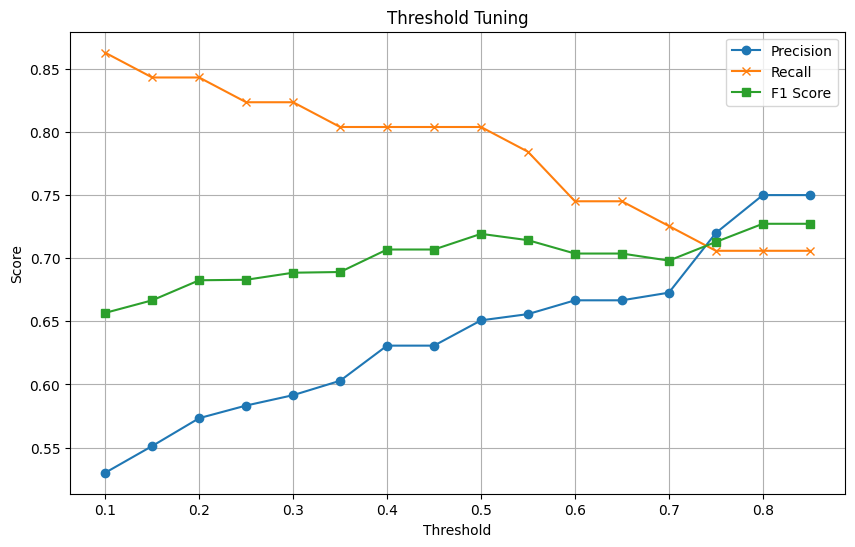

In [13]:
#using SMOTE
""" smote = SMOTE(random_state=42)
X_train_res, Y_train_res = smote.fit_resample(X_train_scaled, Y_train)
model.fit(X_train_res, Y_train_res) """
#smote not very useful

probs = model.predict_proba(X_val_scaled)[:, 1]

# Step 2: Try different thresholds
thresholds = np.arange(0.1, 0.9, 0.05)
precision_scores = []
recall_scores = []
f1_scores = []

for thresh in thresholds:
    preds = (probs > thresh).astype(int)
    precision_scores.append(precision_score(y_val, preds, zero_division=0))
    recall_scores.append(recall_score(y_val, preds))
    f1_scores.append(f1_score(y_val, preds))

# Step 3: Plot the results
plt.figure(figsize=(10, 6))
plt.plot(thresholds, precision_scores, label='Precision', marker='o')
plt.plot(thresholds, recall_scores, label='Recall', marker='x')
plt.plot(thresholds, f1_scores, label='F1 Score', marker='s')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Threshold Tuning')
plt.legend()
plt.grid(True)
plt.show()

Fitting 5 folds for each of 648 candidates, totalling 3240 fits

Best parameters: {'colsample_bytree': 0.8, 'gamma': 0.2, 'learning_rate': 0.1, 'max_depth': 5, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 0.8}

Best precision score: 0.6839241874055487

Best recall score: 0.7294326241134752

Best f1 score: 0.7035769590961994

Best custom score: 0.6975767184179267


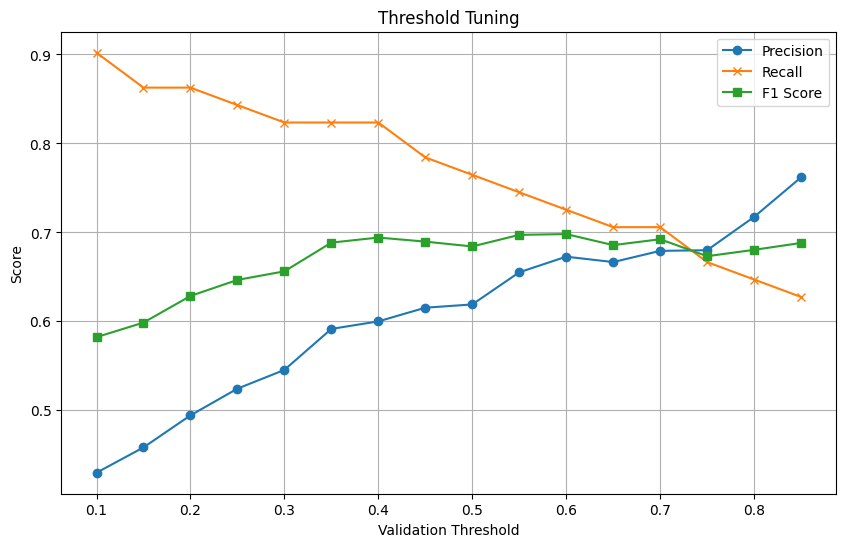

Final Test Report:
               precision    recall  f1-score   support

           0       0.99      0.99      0.99      1449
           1       0.76      0.63      0.69        51

    accuracy                           0.98      1500
   macro avg       0.87      0.81      0.84      1500
weighted avg       0.98      0.98      0.98      1500



'y_pred = best_model.predict(X_val_scaled)\n\nprint("\nBest Model Performance:")\nprint("Accuracy:", accuracy_score(y_val, y_pred))\nprint("Precision:", precision_score(y_val, y_pred))\nprint("Recall:", recall_score(y_val, y_pred))\nprint("F1 Score:", f1_score(y_val, y_pred))\n\nprint("\nConfusion Matrix:")\nprint(confusion_matrix(y_val, y_pred))'

In [14]:
#hyperparameter tuning with GridSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.metrics import classification_report

# Defining parameter grid
param_grid = {
    'max_depth': [3, 4, 5],
    'min_child_weight': [1, 3, 5],
    'gamma': [0, 0.1, 0.2],
    'subsample': [0.8, 0.9],
    'colsample_bytree': [0.8, 0.9],
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [100, 200]
}

# Initializing XGBoost model
base_model = XGBClassifier(
    scale_pos_weight=scale_pos_weight,
    n_jobs=-1,
    eval_metric='logloss',
    random_state=42
)

# Custom scorer that weights precision higher than recall
def custom_scorer(y_true, y_pred):
    prec = precision_score(y_true, y_pred)
    rec = recall_score(y_true, y_pred)
    # Giving more weight to precision (0.7) than recall (0.3)
    return 0.7 * prec + 0.3 * rec

# Updating GridSearchCV with multiple scoring metrics
grid_search = GridSearchCV(
    estimator=base_model,
    param_grid=param_grid,
    cv=5,
    scoring={
        'precision': 'precision',
        'recall': 'recall',
        'f1': 'f1',
        'custom': make_scorer(custom_scorer)
    },
    refit='custom',  # Use custom scorer for selecting best model
    verbose=2,
    n_jobs=-1
)

# Fitting the grid search
grid_search.fit(X_train_scaled, Y_train)

# Printting best parameters and scores for each metric
print("\nBest parameters:", grid_search.best_params_)
for metric in ['precision', 'recall', 'f1', 'custom']:
    print(f"\nBest {metric} score:", grid_search.cv_results_[f'mean_test_{metric}'][grid_search.best_index_])

# Getting the best model and evaluation with threshold tuning
best_model = grid_search.best_estimator_
val_probs = best_model.predict_proba(X_val_scaled)[:, 1]

# Step 2: Try different val_thresholds
val_thresholds = np.arange(0.1, 0.9, 0.05)
precision_scores = []
recall_scores = []
f1_scores = []

for thresh in val_thresholds:
    val_preds = (val_probs > thresh).astype(int)
    precision_scores.append(precision_score(y_val, val_preds, zero_division=0))
    recall_scores.append(recall_score(y_val, val_preds))
    f1_scores.append(f1_score(y_val, val_preds))

# Step 3: Plot the results
plt.figure(figsize=(10, 6))
plt.plot(val_thresholds, precision_scores, label='Precision', marker='o')
plt.plot(val_thresholds, recall_scores, label='Recall', marker='x')
plt.plot(val_thresholds, f1_scores, label='F1 Score', marker='s')
plt.xlabel('Validation Threshold')
plt.ylabel('Score')
plt.title('Threshold Tuning')
plt.legend()
plt.grid(True)
plt.show()
print("Final Test Report:\n", classification_report(y_val, val_preds))

"""y_pred = best_model.predict(X_val_scaled)

print("\nBest Model Performance:")
print("Accuracy:", accuracy_score(y_val, y_pred))
print("Precision:", precision_score(y_val, y_pred))
print("Recall:", recall_score(y_val, y_pred))
print("F1 Score:", f1_score(y_val, y_pred))

print("\nConfusion Matrix:")
print(confusion_matrix(y_val, y_pred))"""

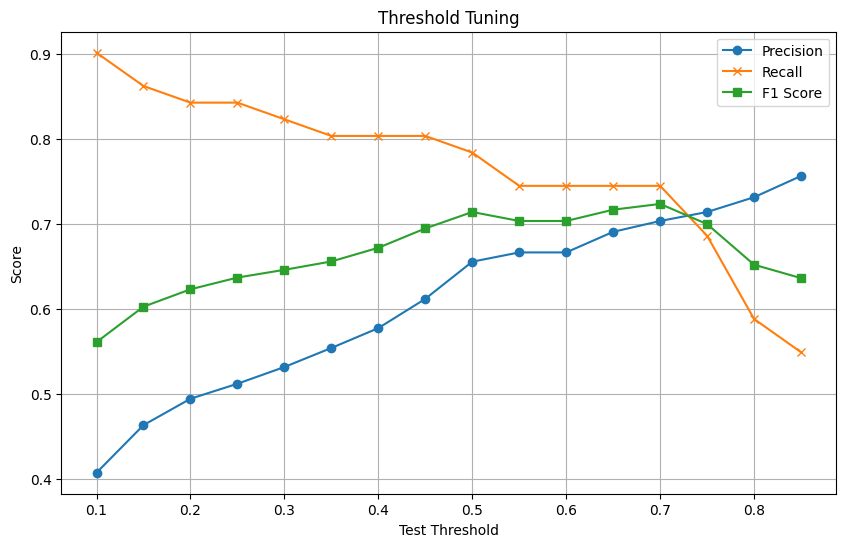

Final Test Report:
               precision    recall  f1-score   support

           0       0.98      0.99      0.99      1449
           1       0.76      0.55      0.64        51

    accuracy                           0.98      1500
   macro avg       0.87      0.77      0.81      1500
weighted avg       0.98      0.98      0.98      1500



In [16]:
# Applying final model with best threshold to test set
test_probs = best_model.predict_proba(X_test_scaled)[:, 1]
test_thresholds = np.arange(0.1, 0.9, 0.05)
precision_scores = []
recall_scores = []
f1_scores = []


for thresh in test_thresholds:
    test_preds = (test_probs > thresh).astype(int)
    precision_scores.append(precision_score(y_test, test_preds, zero_division=0))
    recall_scores.append(recall_score(y_test, test_preds))
    f1_scores.append(f1_score(y_test, test_preds))

# Step 3: Plot the results
plt.figure(figsize=(10, 6))
plt.plot(test_thresholds, precision_scores, label='Precision', marker='o')
plt.plot(test_thresholds, recall_scores, label='Recall', marker='x')
plt.plot(test_thresholds, f1_scores, label='F1 Score', marker='s')
plt.xlabel('Test Threshold')
plt.ylabel('Score')
plt.title('Threshold Tuning')
plt.legend()
plt.grid(True)
plt.show()

print("Final Test Report:\n", classification_report(y_test, test_preds))

In [26]:
# Final model training and evaluation
# Final model training with the best parameters from grid search

# Train the final model
final_model = XGBClassifier(
    colsample_bytree=0.8,
    gamma=0.2,
    learning_rate=0.1,
    max_depth=5,
    min_child_weight=1,
    n_estimators=200,
    subsample=0.8,
    eval_metric='logloss',
    random_state=42
)

final_model.fit(X_train_scaled, Y_train)

# Predictting probabilities for validation and test
val_probs = final_model.predict_proba(X_val_scaled)[:, 1]
test_probs = final_model.predict_proba(X_test_scaled)[:, 1]

# Threshold tuning (the best one from my analysis)
threshold = 0.2  # This threshold can be adjusted based on the previous analysis

# Apply threshold
val_preds = (val_probs >= threshold).astype(int)
test_preds = (test_probs >= threshold).astype(int)

# Evaluation on validation
val_precision = precision_score(y_val, val_preds, zero_division=0)
val_recall = recall_score(y_val, val_preds)
val_f1 = f1_score(y_val, val_preds)

# Evaluation on test
test_precision = precision_score(y_test, test_preds)
test_recall = recall_score(y_test, test_preds)
test_f1 = f1_score(y_test, test_preds)
test_accuracy = accuracy_score(y_test, test_preds)

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, test_preds)

# Display metrics
print("=== Final Model Evaluation ===")
print(f"Validation Precision: {val_precision}")
print(f"Validation Recall: {val_recall}")
print(f"Validation F1 Score: {val_f1}")
print(f"Threshold: {threshold}")
print(f"Test Accuracy: {test_accuracy}")
print(f"Test Precision: {test_precision}")
print(f"Test Recall: {test_recall}")
print(f"Test F1 Score: {test_f1}")
print("Confusion Matrix:")
print(conf_matrix)


=== Final Model Evaluation ===
Validation Precision: 0.6461538461538462
Validation Recall: 0.8235294117647058
Validation F1 Score: 0.7241379310344828
Threshold: 0.2
Test Accuracy: 0.9746666666666667
Test Precision: 0.6101694915254238
Test Recall: 0.7058823529411765
Test F1 Score: 0.6545454545454545
Confusion Matrix:
[[1426   23]
 [  15   36]]


In [27]:
import joblib
joblib.dump(final_model, 'best_xgb_model.pkl')


['best_xgb_model.pkl']

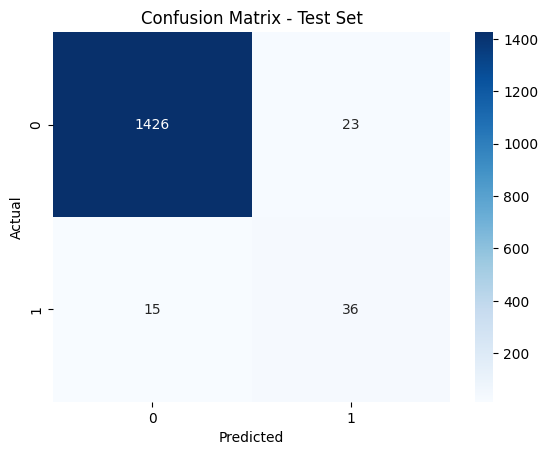

In [28]:
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix - Test Set")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()